In [1]:
import os
os.chdir('../')

import pickle as pkl
import pandas as pd
import seaborn as sns

sns.set(style='darkgrid', palette='muted')

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from itertools import combinations
from sklearn.inspection import PartialDependenceDisplay, DecisionBoundaryDisplay

In [2]:
with open('models/sgdc.pkl', 'rb') as file:
    sgdc = pkl.load(file)

In [3]:
data = pd.read_csv('data/selected/data.csv')

In [4]:
X, y = data.drop('estado al egreso', axis=1), data['estado al egreso']

### Feature Importance

In [5]:
coef = sgdc.named_steps['estimator'].coef_[0]
feature_names = X.columns 

importances = pd.Series(coef, index=feature_names)
importances

edad                       -11.851045
trastorno de consciencia     1.689271
apache                     -43.282679
ilg                         -9.462990
dtype: float64

### Decision Regions Analysis

#### Voronoi Based Decision Boundary 2d Visualization

<Figure size 1000x600 with 0 Axes>

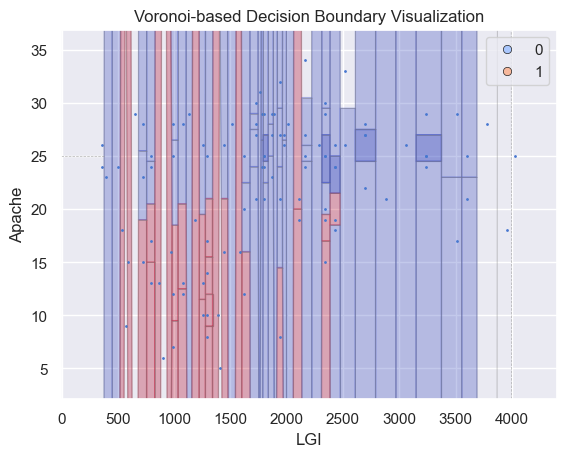

In [6]:
features = ['ilg', 'apache']
X_features = X[features].values
y_pred = sgdc.predict(X)
vor = Voronoi(X_features)

plt.figure(figsize=(10, 6))
voronoi_plot_2d(vor, show_vertices=False, line_colors='gray', line_width=0.5, line_alpha=0.6, point_size=2)

for region, pred in zip(vor.point_region, y_pred):
    if -1 not in vor.regions[region]:
        polygon = [vor.vertices[i] for i in vor.regions[region]]
        plt.fill(*zip(*polygon), alpha=0.3, color=sns.color_palette("coolwarm", as_cmap=True)(pred / max(y)))

sns.scatterplot(x=X_features[:, 1], y=X_features[:, 0], hue=y.to_numpy(), palette="coolwarm", edgecolor='k')

plt.title("Voronoi-based Decision Boundary Visualization")
plt.xlabel('LGI')
plt.ylabel('Apache')
plt.show()


#### Partial Dependence Plot (PDP) – 2D Contour

The plot shows that lower values of both apache and ilg are associated with a higher predicted survive probability.
As either apache or ilg increases, the predicted probability of the positive class decreases.

There is a combined nonlinear effect where both high apache and high ilg contribute to a lower survive change.
This suggests that both features play a strong role in the model’s predictions, and their effects are interdependent.

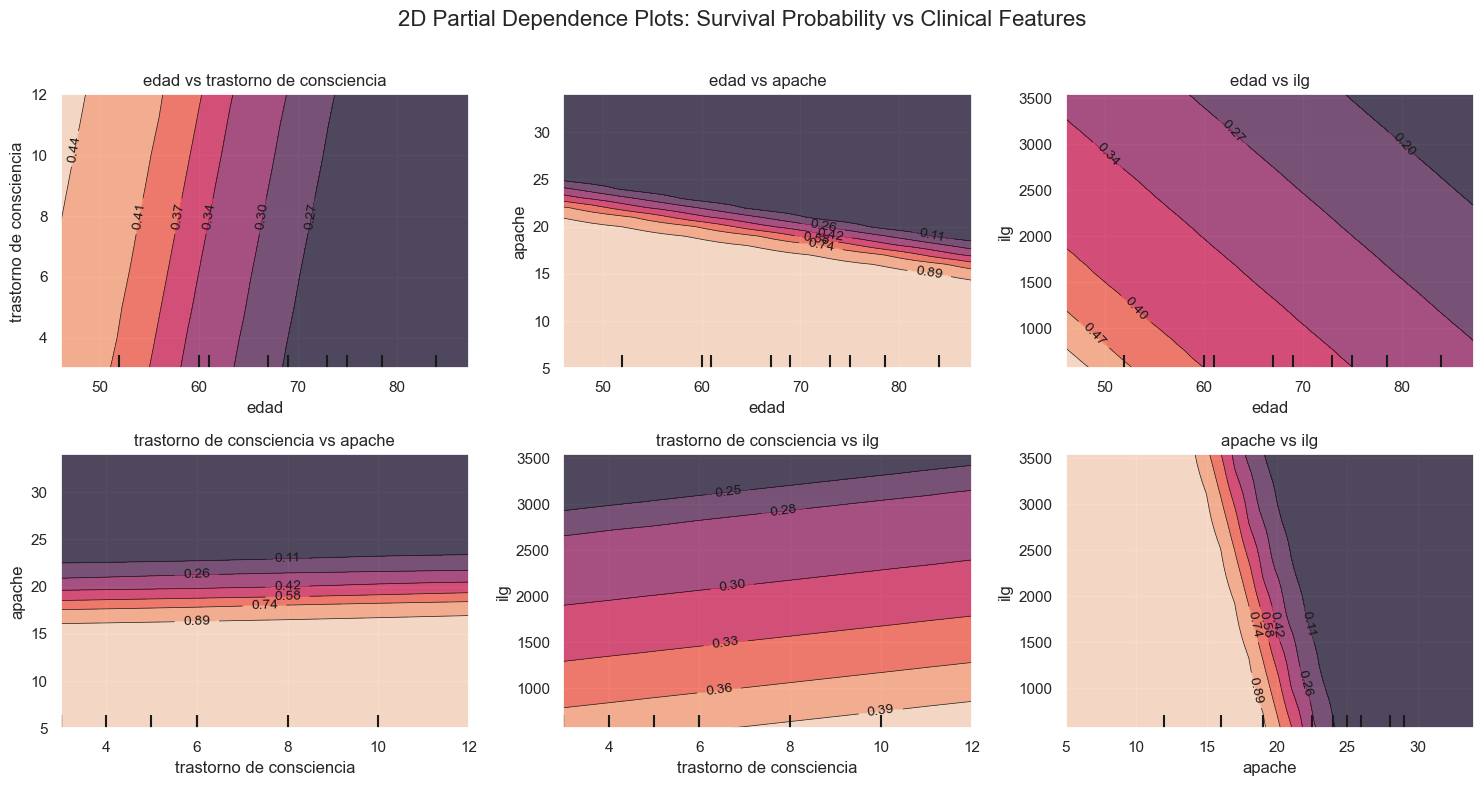

In [7]:
# Define feature pairs
feature_names = X.columns.tolist()
feature_pairs = list(combinations(feature_names, 2))

n_cols = 3 
n_rows = (len(feature_pairs) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, pair in enumerate(feature_pairs):
    PartialDependenceDisplay.from_estimator(
        sgdc,
        X,
        features=[pair],
        response_method="predict_proba",
        kind="average",
        grid_resolution=30,
        ax=axes[i],
    )
    axes[i].set_title(f"{pair[0]} vs {pair[1]}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("2D Partial Dependence Plots: Survival Probability vs Clinical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()